# Content-based Filtering Group Explanations

In [52]:
import pandas as pd
import numpy as np
import time
import math
from math import sqrt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from xgboost import XGBRegressor
import pickle
from itertools import chain

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
random.seed(42)

In [2]:
# load data
data_folder = '../data/'
user_item_ratings_reduced = pd.read_csv(f'{data_folder}user_ratings_reduced.csv')
user_item_ratings_reduced = user_item_ratings_reduced.drop(columns=["Unnamed: 0"])
item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
item_info = pd.read_csv(data_folder + 'games.csv')
item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
item_themes = pd.read_csv(data_folder + 'themes.csv')

In [14]:
# load groups
filename = '../group_data/clusters_ids.npy'
groups = np.load(filename, allow_pickle=True)

In [3]:
# user_item_ratings_reduced['rating'] = user_item_ratings_reduced['rating'].round(0).astype(int)

In [5]:
user_item_rating_count = user_item_ratings_reduced.groupby('user').count()

In [6]:
min_rating_count = 10
user_rating_count = user_item_rating_count[user_item_rating_count['rating'] >= min_rating_count]
user_list_filtered = list(user_rating_count.index)
user_item_ratings_filtered = user_item_ratings_reduced[user_item_ratings_reduced['user'].isin(user_list_filtered)]

### Preprocessing

In [7]:
# item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
# item_info = pd.read_csv(data_folder + 'games.csv')
# item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
# item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
# item_themes = pd.read_csv(data_folder + 'themes.csv')

In [8]:
item_info.rename(columns={'BGGId':'item'},inplace=True)
# get comeplete user-catalog data
user_item_complete = pd.merge(user_item_ratings_filtered, item_info, on='item', how='inner')
# item_info.info() 
# item_info[['GoodPlayers', 'Family', 'ImagePath']].head()
non_numerical_features = ['user','Name','Description', 'item', 'GoodPlayers', 'Family', 'ImagePath']

In [9]:
# find a median rating for each user
median_rating = user_item_complete.groupby('user')['rating'].median().rename('median_rating').reset_index()
user_item_complete = pd.merge(user_item_complete, median_rating, on='user', how='inner')

User-Item matrix has size (1_228_331, 51) after selecting users with >= `min_rating_count`

User-Item matrix has size (771_551, 51) after selecting items for users with rating higher than their mean rating

In [11]:
def get_all_items_for_user(username, complete_df):
    return complete_df[complete_df['user']==username].drop(columns=['user'])  

In [37]:
def get_all_items_for_group(group_ids, complete_df):
    return complete_df[complete_df['user'].isin(group_ids)]

In [13]:
def add_avg_group_rating(selected_items, group, complete):
    selected_items.reset_index(drop=True, inplace=True)
    selected_items['avg_group_rating'] = 0
    group_users = group['user'].unique()
    for index,item in selected_items.iterrows():
        item_in_group = complete[(complete['user'].isin(group_users))&(complete['item']==item['item'])]
        average_group_rating = item_in_group['rating'].mean()
        item['avg_group_rating'] = average_group_rating
        selected_items.iloc[index,:] = item
        
    return selected_items
        

In [22]:
def save(obj):
    def get_variable_name(var):
        # Iterate over the global variables
        for name, value in globals().items():
            if value is var:
                return name
        return None
    name = get_variable_name(obj)
    with open("saved/"+name+".pkl", "wb") as f: # "wb" because we want to write in binary mode
        pickle.dump(obj, f)
        
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [15]:
group0 = groups[0]
g0_items = get_all_items_for_group(group0, user_item_complete)
g0_items.shape

In [19]:
from cb_features import cb_features
final_item_features = ['item','user','rating']+cb_features

In [20]:
mechanics_features = ['mechanic_' + i if not i == 'BGGId' else i for i in item_mecahnics.columns]
subcategory_features = ['subcategory_' + i if not i == 'BGGId' else i for i in item_subcategories.columns]
theme_features = ['theme_' + i.split('_')[-1] if not i == 'BGGId' else i for i in item_themes.columns]

item_mecahnics.columns = mechanics_features
item_subcategories.columns = subcategory_features
item_themes.columns = theme_features

item_catalog = pd.merge(item_mecahnics, item_subcategories, on='BGGId', how='outer')
item_catalog = pd.merge(item_catalog, item_themes, on='BGGId', how='outer')

In [21]:
user_item_selected = user_item_complete[final_item_features]
user_item_all_features = pd.merge(user_item_selected, item_catalog, left_on='item', right_on='BGGId', how='left')

In [40]:
user_item_all_features['ComAgeRec'].fillna(value=user_item_all_features['ComAgeRec'].mean(), inplace=True)

In [22]:
user_item_all_features.select_dtypes(include=['object']).columns

Index(['user'], dtype='object')

In [55]:
all_user_names = user_item_all_features.user.unique()

In [33]:
def generate_Xy_for_group(group_ids, complete_df):
    scaler = StandardScaler()
    group_rated_items = get_all_items_for_group(group_ids,complete_df)
    index_x = group_rated_items.index
    X = group_rated_items.drop(columns=['user','rating', 'item'])
    normalized_matrix = scaler.fit_transform(X)
    X =  pd.DataFrame(normalized_matrix, columns=X.columns, index=index_x)
    y = group_rated_items['rating']
    return X,y

In [41]:
X,y = generate_Xy_for_group(group0,user_item_all_features[final_item_features])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=42)

In [42]:
svr = SVR(kernel='linear')
svr.fit(train_X, train_y)

SVR(kernel='linear')

In [43]:
predicted_y = svr.predict(test_X)

In [44]:
item_rating = test_y.to_frame().copy()
item_rating['predicted'] = predicted_y

## Evaluation

In [113]:
def get_random_group(all_groups,n=10):
    index_range = [*range(0,len(all_groups))]
    n = min(n, len(index_range))
    if n == len(index_range):
        print('take all the groups shuffled')

    nbr = random.sample(index_range, n)
    groups_for_test = []
    for i in nbr:
        groups_for_test.append(all_groups[i])
    return groups_for_test

In [86]:
num_groups_test = 10
groups_for_test =  get_random_group(groups, 100)

take all the groups shuffled
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]


In [87]:
# RMSE
((item_rating['rating']-item_rating['predicted'])**2).mean(0)**0.5

1.5047059545374433

In [88]:
# MAE
(abs(item_rating['rating']-item_rating['predicted'])).mean(0)

1.1899608701982072

In [89]:
def evaluate_groups(groups, user_item_all_features, regressor):
    RMSEs = []
    MAEs = []
    for group in groups:
        print(group)
        X,y = generate_Xy_for_group(group,user_item_all_features)
        train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
        
        regressor.fit(train_X, train_y)
        predicted_y = regressor.predict(test_X)
        
        item_ratings = test_y.to_frame().copy()
        item_ratings['predicted'] = predicted_y
        
        RMSEs.append(((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5)
        MAEs.append((abs(item_ratings['rating']-item_ratings['predicted'])).mean(0))
        
    return RMSEs, MAEs

In [91]:
regressor = SVR(kernel='linear')
RMSEs, MAEs = evaluate_groups(groups_for_test, user_item_all_features[final_item_features], regressor)

['Bernhard N.', 'kathuna']
['Larry Chong', 'OGRussHood', 'Thunkd', 'XSNRG', '_tk_']
['Baartoszz', 'Daramere', 'Dharquen', 'Funfairist', 'HilkMAN']
['Govin', 'Lord Heisemberg', 'Michael Becker', 'Mr Mjeh', 'chriswray84']
['Gylas', 'dooz']
['ChrB', 'UFo11', 'dafair', 'iMisut', 'joelbear']
['Geeken', 'Hubajube', 'Kweevnidny', 'Octavian', 'Orski']
['Banker', 'Cinful', 'Downblaw', 'JesseW', 'Joe Miner']
['Boromir1983', 'FC Dynamo Turbine', 'RhodesN7', 'StevenBedell', 'Yacoff']
['Comrade_Sarayev', 'Rococo_Zephyr', 'Torquin', 'exo20811', 'fuzzyfife']
['JAskier', 'ct5150', 'frogmind']
['Earl of Dukes', 'Toph', 'ZeeGarcia', 'cdefrisco', 'jjrbedford']
['Ender667', 'Jim_P', 'Sarsi', 'steinhauser', 'unshod']
['Hristo Filipov', 'nnf1']
['Cyberian', 'DDPage', 'Happymrdave', 'StormKnight', 'arsior']
['AnttiT', 'BlueTorch', 'Butterfly0038', 'Deinos', 'DiSta']
['Bixby', 'CharlieWonka', 'cowhollow', 'shreyank', 'vincivader']
['IceScrat', 'Phoenixgeek', 'calvo', 'ijohsua', 'raile']
['Grildensnork', 'Went

In [92]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)

In [93]:
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.36  | MAE: 1.04


In [94]:
regressor = DecisionTreeRegressor()
RMSEs, MAEs = evaluate_groups(groups_for_test, user_item_all_features[final_item_features], regressor)

['Bernhard N.', 'kathuna']
['Larry Chong', 'OGRussHood', 'Thunkd', 'XSNRG', '_tk_']
['Baartoszz', 'Daramere', 'Dharquen', 'Funfairist', 'HilkMAN']
['Govin', 'Lord Heisemberg', 'Michael Becker', 'Mr Mjeh', 'chriswray84']
['Gylas', 'dooz']
['ChrB', 'UFo11', 'dafair', 'iMisut', 'joelbear']
['Geeken', 'Hubajube', 'Kweevnidny', 'Octavian', 'Orski']
['Banker', 'Cinful', 'Downblaw', 'JesseW', 'Joe Miner']
['Boromir1983', 'FC Dynamo Turbine', 'RhodesN7', 'StevenBedell', 'Yacoff']
['Comrade_Sarayev', 'Rococo_Zephyr', 'Torquin', 'exo20811', 'fuzzyfife']
['JAskier', 'ct5150', 'frogmind']
['Earl of Dukes', 'Toph', 'ZeeGarcia', 'cdefrisco', 'jjrbedford']
['Ender667', 'Jim_P', 'Sarsi', 'steinhauser', 'unshod']
['Hristo Filipov', 'nnf1']
['Cyberian', 'DDPage', 'Happymrdave', 'StormKnight', 'arsior']
['AnttiT', 'BlueTorch', 'Butterfly0038', 'Deinos', 'DiSta']
['Bixby', 'CharlieWonka', 'cowhollow', 'shreyank', 'vincivader']
['IceScrat', 'Phoenixgeek', 'calvo', 'ijohsua', 'raile']
['Grildensnork', 'Went

In [95]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.81  | MAE: 1.37


In [96]:
regressor = XGBRegressor()
RMSEs, MAEs = evaluate_groups(groups_for_test, user_item_all_features[final_item_features], regressor)

['Bernhard N.', 'kathuna']
['Larry Chong', 'OGRussHood', 'Thunkd', 'XSNRG', '_tk_']
['Baartoszz', 'Daramere', 'Dharquen', 'Funfairist', 'HilkMAN']
['Govin', 'Lord Heisemberg', 'Michael Becker', 'Mr Mjeh', 'chriswray84']
['Gylas', 'dooz']
['ChrB', 'UFo11', 'dafair', 'iMisut', 'joelbear']
['Geeken', 'Hubajube', 'Kweevnidny', 'Octavian', 'Orski']
['Banker', 'Cinful', 'Downblaw', 'JesseW', 'Joe Miner']
['Boromir1983', 'FC Dynamo Turbine', 'RhodesN7', 'StevenBedell', 'Yacoff']
['Comrade_Sarayev', 'Rococo_Zephyr', 'Torquin', 'exo20811', 'fuzzyfife']
['JAskier', 'ct5150', 'frogmind']
['Earl of Dukes', 'Toph', 'ZeeGarcia', 'cdefrisco', 'jjrbedford']
['Ender667', 'Jim_P', 'Sarsi', 'steinhauser', 'unshod']
['Hristo Filipov', 'nnf1']
['Cyberian', 'DDPage', 'Happymrdave', 'StormKnight', 'arsior']
['AnttiT', 'BlueTorch', 'Butterfly0038', 'Deinos', 'DiSta']
['Bixby', 'CharlieWonka', 'cowhollow', 'shreyank', 'vincivader']
['IceScrat', 'Phoenixgeek', 'calvo', 'ijohsua', 'raile']
['Grildensnork', 'Went

In [97]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.49  | MAE: 1.14


# Generating Explanations

In [101]:
random_user = get_random_group(groups,1)[0]
random_user

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]


['starfix', 'xanthie']

In [102]:
tree_regressor = DecisionTreeRegressor(random_state=42)

In [103]:
X, y = generate_Xy_for_group(random_user, user_item_all_features[final_item_features])

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
tree_regressor.fit(train_X, train_y)
predicted_y = tree_regressor.predict(test_X)

item_ratings = test_y.to_frame().copy()
item_ratings['predicted'] = predicted_y
        
RMSE = ((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5
MAE = (abs(item_ratings['rating']-item_ratings['predicted'])).mean(0)

In [104]:
interacted_items = user_item_complete[user_item_complete.index.isin(X.index)]

In [105]:
test_items = user_item_complete[user_item_complete.index.isin(test_X.index)]

In [106]:
# text_representation = tree.export_text(tree_regressor)
# print(text_representation)

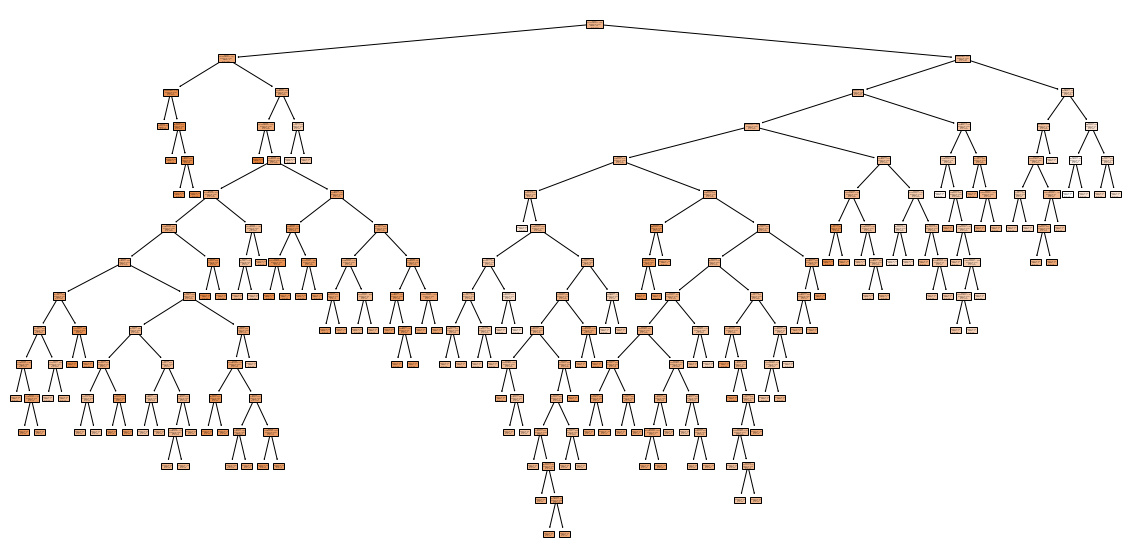

In [107]:
# Plot the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(tree_regressor, filled=True, feature_names=X.columns,node_ids=True)
plt.show()

In [108]:
# calculate feature importances for a prediction

# select features used to create a prediction
decision_path = tree_regressor.decision_path([test_X.iloc[0,:]])
node_indices = decision_path.indices
feature_indices = tree_regressor.tree_.feature
feature_names = test_X.columns  # Replace with your actual feature names
used_features = [feature_names[i] for i in feature_indices[node_indices] if i > 0]
used_features

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


['Rank:strategygames',
 'Rank:strategygames',
 'GameWeight',
 'Rank:strategygames',
 'GameWeight',
 'NumWeightVotes',
 'NumWeightVotes',
 'NumOwned',
 'NumWant',
 'NumWant',
 'NumWant',
 'NumOwned',
 'NumWeightVotes']

In [109]:
def get_features_sorted(selected_featurenames, feature_names, feature_importances):
    # Create a list of tuples (feature_name, feature_importance)
    feature_importance_tuples = list(zip(feature_names, feature_importances))
    
    # Sort the list of tuples by feature importance in descending order
    sorted_features = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
    sorted_features = [s for s in sorted_features if s[0] in selected_featurenames]
    return sorted_features

In [110]:
get_features_sorted(used_features, test_X.columns, tree_regressor.feature_importances_)

[('Rank:strategygames', 0.22124535793076835),
 ('NumWant', 0.12743288120309065),
 ('GameWeight', 0.10809581338540336),
 ('NumWeightVotes', 0.09617649661010012),
 ('NumOwned', 0.045799927896641744)]

In [111]:
node_indicator = decision_path
leaf_id = tree_regressor.apply([test_X.iloc[0,:]])
for node_id in node_indices:
    # continue to the next node if it is a leaf node
    # if leaf_id[sample_id] == node_id:
    #     continue
    if node_id==leaf_id:
        continue
    
    print(
        "decision node {node} : X_test[{sample},{feature}]".format(
            node=node_id,
            sample=node_id,
            feature=feature_indices[node_id],
        )
    )


decision node 0 : X_test[0,17]
decision node 1 : X_test[1,17]
decision node 9 : X_test[9,5]
decision node 10 : X_test[10,17]
decision node 12 : X_test[12,5]
decision node 13 : X_test[13,14]
decision node 14 : X_test[14,14]
decision node 15 : X_test[15,12]
decision node 29 : X_test[29,13]
decision node 30 : X_test[30,13]
decision node 38 : X_test[38,13]
decision node 42 : X_test[42,12]
decision node 43 : X_test[43,14]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Showcase

In [114]:
sc_group = get_random_group(groups,1)[0]
X, y = generate_Xy_for_group(sc_group, user_item_all_features[final_item_features])
print(f"Group: {sc_group} | Number of interactions: {X.shape[0]}")

Group: ['Geese', 'Glamorous Mucus', 'Karmic_devil', 'Master Thomas', 'Nightmare'] | Number of interactions: 683


In [115]:
# train a tree
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
tree_regressor.fit(train_X, train_y)
predicted_y = tree_regressor.predict(test_X)

item_ratings = test_y.to_frame().copy()
item_ratings['predicted'] = predicted_y
        
RMSE = ((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5
MAE = (abs(item_ratings['rating']-item_ratings['predicted'])).mean(0)

interacted_items = user_item_complete[user_item_complete.index.isin(X.index)]
test_items = user_item_complete[user_item_complete.index.isin(test_X.index)]
important_features = ['Name']+final_item_features

In [116]:
def explain_prediction(item_data, test_X, tree_reg, k=3):
    """ will explain the recommendation using top k important features for the particular item"""
    item_id = item_data.name
    item_Name = item_data.Name
    test_ids = test_X.index
    if item_id not in test_ids:
        return "No such item in the test set"
    
    decision_path = tree_regressor.decision_path([test_X.loc[item_id,:]])
    node_indices = decision_path.indices
    feature_indices = tree_regressor.tree_.feature
    feature_names = test_X.columns 
    #print(feature_names)
    used_features = [feature_names[i] for i in feature_indices[node_indices] if i > 0]
    # print(used_features)
    selected_features = get_features_sorted(used_features, feature_names, tree_regressor.feature_importances_)
    # print(selected_features)
    
    explaining_fs = []
    for f in selected_features:
        explaining_fs.append(f[0])
    
    #print(selected_features)
    k = min(len(explaining_fs), k)
        
    if len(explaining_fs):
        # return f"The game '{item_Name}' is recommended to you because you like games in the following categories: {', '.join(explaining_fs)}"
        return explaining_fs[:k], item_Name

In [117]:
item = test_items[important_features].sample(1).iloc[0]
exp_fs,gname = explain_prediction(item, test_X, tree_regressor, k=3)
exp_fs,gname

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(['Rank:boardgame', 'GameWeight', 'NumWeightVotes'], 'Imperios Milenarios')

In [1]:
from explanations import cat_fs, num_fs, rank_fs, other_fs, connectors

def write_explanation(explanation_fs, game_name):
    print(f'INPUT: Features: {explanation_fs}, game: [{game_name}]')
    rank_exp = 'we noticed that you like board games ranked high in the '
    num_exp = 'we found that you like board games which'
    cat_exp = 'we observed that you like board games in '
    other_exp = 'we spotted that you put a lot of emphasis on '
    connector = ''
    count = 0
    
    explanation = f'The game {game_name} is recommended to you because '
    
    # rank explanation
    rank_active_exps = [rank_fs[f] for f in explanation_fs if f in rank_fs.keys()]
    if len(rank_active_exps) > 1:
        explanation += rank_exp + ', '.join(rank_active_exps) + ' rankings.\n'
        count += 1
    elif len(rank_active_exps) == 1:
        explanation += rank_exp + rank_active_exps[0] + ' ranking.\n'
        count += 1
        
    # count explanation
    num_active_exps = [num_fs[f] for f in explanation_fs if f in num_fs.keys()]
    if len(num_active_exps) > 1:
        explanation += connectors[count] + num_exp + ', '.join(num_active_exps) + ' .\n'
        count += 1
    elif len(num_active_exps) == 1:
        explanation += connectors[count] + num_exp + num_active_exps[0] + ' .\n'
        count += 1
        
    # category explanations
    cat_active_exps = [cat_fs[f] for f in explanation_fs if f in cat_fs.keys()]
    if len(cat_active_exps) > 1:
        explanation += connectors[count] + cat_exp + ', '.join(cat_active_exps) + ' categories.\n'
        count += 1
    elif len(cat_active_exps) == 1:
        explanation += connectors[count] + cat_exp + cat_active_exps[0] + ' category.\n'
        count += 1
    
    other_active_exps = [other_fs[f] for f in explanation_fs if f in other_fs.keys()]
    if len(other_active_exps) > 1:
        explanation += connectors[count] + other_exp  + ', '.join(other_active_exps) + ' when selecting games.\n'
    elif len(other_active_exps) == 1:
        explanation += connectors[count] + other_exp + other_active_exps[0] + ' when selecting games.\n'
        
    return explanation    

In [2]:
print(write_explanation(exp_fs, gname))

NameError: name 'exp_fs' is not defined

Example: 
```
INPUT: Features: ['Rank:boardgame', 'GameWeight', 'NumWeightVotes'], game: [Imperios Milenarios]
The game Imperios Milenarios is recommended to you because we noticed that you like board games ranked high in the general ranking.
Also, we spotted that you put a lot of emphasis on easiness/difficulty of a game when selecting games.
```